In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from dask import compute,delayed
from tensorflow.keras import applications

In [2]:
train_folder = '/home/will/Desktop/Kaggle/Whale/train'
test_folder = '/home/will/Desktop/Kaggle/Whale/test'
train_preprocess_folder = '/home/will/Desktop/Kaggle/Whale/train_preprocess'
test_preprocess_folder = '/home/will/Desktop/Kaggle/Whale/test_preprocess'

In [3]:
if not os.path.isdir(train_preprocess_folder):
    os.mkdir(train_preprocess_folder)

In [4]:
if not os.path.isdir(test_preprocess_folder):
    os.mkdir(test_preprocess_folder)

In [5]:
preprocess_input = applications.xception.preprocess_input

In [31]:
%%time
test_shapes = [cv2.imread(test_folder+'/'+img,cv2.IMREAD_UNCHANGED).shape for img in os.listdir(test_folder)]

CPU times: user 31.8 s, sys: 380 ms, total: 32.2 s
Wall time: 32.3 s


In [34]:
%%time
test_shapes2 = [delayed(cv2.imread)(test_folder+'/'+img,cv2.IMREAD_UNCHANGED).shape
                for img in os.listdir(test_folder)]
test_shapes2=compute(*test_shapes2)

CPU times: user 36.9 s, sys: 793 ms, total: 37.7 s
Wall time: 10.5 s


In [81]:
%%time
test_shapes2 = [delayed(cv2.imread)(train_folder+'/'+img,cv2.IMREAD_UNCHANGED).shape
                for img in os.listdir(train_folder)]
test_shapes2=compute(*test_shapes2)

CPU times: user 1min 57s, sys: 2.58 s, total: 2min
Wall time: 35.2 s


In [6]:
@delayed
def process_img(in_path,out_path,size=(256,256)):
    img = cv2.resize(cv2.imread(in_path,cv2.IMREAD_UNCHANGED),size)
    if len(img.shape) == 2:
        img = np.tile(img[:,:,np.newaxis],(1, 1, 3))
    else:
        img = img[:,:,::-1]
    img = preprocess_input(img)
    np.save(out_path,img.astype(np.float32))

In [7]:
%%time
save_images  = [process_img(train_folder+'/'+img,
                            train_preprocess_folder+'/'+img.split('.')[0])
                for img in os.listdir(train_folder)]
compute(*save_images)

CPU times: user 4min 34s, sys: 5min 55s, total: 10min 30s
Wall time: 2min 39s


In [8]:
%%time
save_images  = [process_img(test_folder+'/'+img,
                            test_preprocess_folder+'/'+img.split('.')[0])
                for img in os.listdir(test_folder)]
compute(*save_images)

CPU times: user 1min 26s, sys: 1min 51s, total: 3min 17s
Wall time: 50.2 s


## train dataset

In [96]:
unique, counts = np.unique([len(s) for s in test_shapes2],return_counts=True)

In [97]:
# mostly color with 3 channels
print(np.asarray((unique, counts)).T)

[[    2  3386]
 [    3 21975]]


In [98]:
l,h = list(zip(*test_shapes2))

(array([4.500e+01, 3.240e+02, 1.264e+03, 2.463e+03, 2.917e+03, 3.888e+03,
        3.705e+03, 4.583e+03, 5.215e+03, 7.610e+02, 1.450e+02, 2.500e+01,
        1.600e+01, 3.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00,
        1.000e+00, 3.000e+00]),
 array([  30.  ,  107.25,  184.5 ,  261.75,  339.  ,  416.25,  493.5 ,
         570.75,  648.  ,  725.25,  802.5 ,  879.75,  957.  , 1034.25,
        1111.5 , 1188.75, 1266.  , 1343.25, 1420.5 , 1497.75, 1575.  ]),
 <a list of 20 Patch objects>)

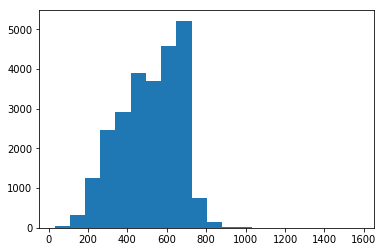

In [99]:
plt.hist(l,bins=20)

(array([2.0700e+02, 1.3920e+03, 4.2930e+03, 1.9047e+04, 9.0000e+01,
        1.3300e+02, 3.5000e+01, 2.9000e+01, 5.5000e+01, 1.8000e+01,
        1.4000e+01, 9.0000e+00, 1.0000e+01, 2.0000e+00, 4.0000e+00,
        2.0000e+00, 0.0000e+00, 2.0000e+00, 2.0000e+00, 1.7000e+01]),
 array([  77. ,  371.1,  665.2,  959.3, 1253.4, 1547.5, 1841.6, 2135.7,
        2429.8, 2723.9, 3018. , 3312.1, 3606.2, 3900.3, 4194.4, 4488.5,
        4782.6, 5076.7, 5370.8, 5664.9, 5959. ]),
 <a list of 20 Patch objects>)

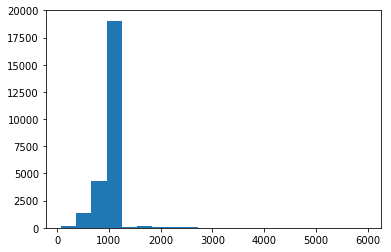

In [100]:
plt.hist(h,bins=20)

(array([6.6000e+01, 1.3213e+04, 6.5590e+03, 2.6350e+03, 1.5290e+03,
        7.6100e+02, 2.9800e+02, 1.6100e+02, 5.1000e+01, 3.0000e+01,
        1.4000e+01, 1.2000e+01, 2.2000e+01, 2.0000e+00, 4.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.50086655,  1.13889141,  1.77691626,  2.41494111,  3.05296597,
         3.69099082,  4.32901568,  4.96704053,  5.60506539,  6.24309024,
         6.88111509,  7.51913995,  8.1571648 ,  8.79518966,  9.43321451,
        10.07123937, 10.70926422, 11.34728907, 11.98531393, 12.62333878,
        13.26136364]),
 <a list of 20 Patch objects>)

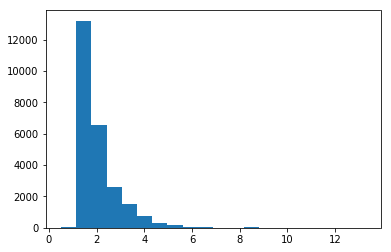

In [101]:
# aspect ratio
plt.hist([temp[1]/temp[0] for temp in test_shapes2],bins=20)

## test dataset

In [55]:
unique, counts = np.unique([len(s) for s in test_shapes2],return_counts=True)

In [59]:
# mostly color with 3 channels
print(np.asarray((unique2, counts2)).T)

[[   2  823]
 [   3 7137]]


In [69]:
l,h = list(zip(*test_shapes2))

(array([2.500e+01, 9.600e+01, 2.020e+02, 4.220e+02, 6.200e+02, 6.520e+02,
        1.112e+03, 5.610e+02, 7.010e+02, 1.213e+03, 2.990e+02, 1.812e+03,
        1.760e+02, 4.700e+01, 1.500e+01, 2.000e+00, 1.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([  66.  ,  122.65,  179.3 ,  235.95,  292.6 ,  349.25,  405.9 ,
         462.55,  519.2 ,  575.85,  632.5 ,  689.15,  745.8 ,  802.45,
         859.1 ,  915.75,  972.4 , 1029.05, 1085.7 , 1142.35, 1199.  ]),
 <a list of 20 Patch objects>)

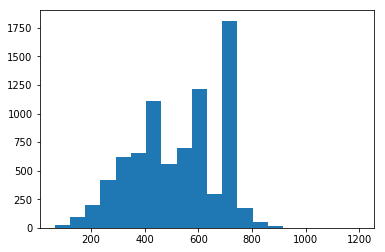

In [74]:
plt.hist(l,bins=20)

(array([1.180e+02, 7.600e+02, 1.217e+03, 5.706e+03, 2.300e+01, 6.100e+01,
        1.300e+01, 8.000e+00, 1.900e+01, 4.000e+00, 1.000e+01, 5.000e+00,
        7.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 3.000e+00]),
 array([ 126.  ,  417.65,  709.3 , 1000.95, 1292.6 , 1584.25, 1875.9 ,
        2167.55, 2459.2 , 2750.85, 3042.5 , 3334.15, 3625.8 , 3917.45,
        4209.1 , 4500.75, 4792.4 , 5084.05, 5375.7 , 5667.35, 5959.  ]),
 <a list of 20 Patch objects>)

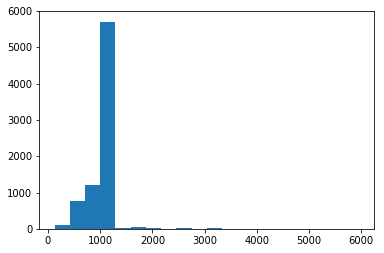

In [75]:
plt.hist(h,bins=20)

(array([9.900e+01, 4.273e+03, 2.020e+03, 7.440e+02, 4.440e+02, 2.000e+02,
        9.100e+01, 3.700e+01, 2.000e+01, 8.000e+00, 4.000e+00, 5.000e+00,
        1.000e+00, 6.000e+00, 4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        3.000e+00, 1.000e+00]),
 array([ 0.74316406,  1.32055985,  1.89795564,  2.47535142,  3.05274721,
         3.630143  ,  4.20753879,  4.78493457,  5.36233036,  5.93972615,
         6.51712194,  7.09451772,  7.67191351,  8.2493093 ,  8.82670509,
         9.40410087,  9.98149666, 10.55889245, 11.13628824, 11.71368402,
        12.29107981]),
 <a list of 20 Patch objects>)

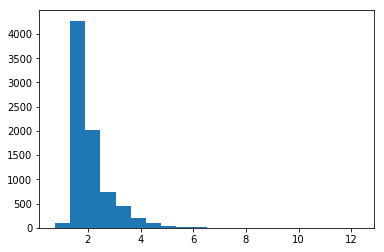

In [76]:
# aspect ratio
plt.hist([temp[1]/temp[0] for temp in test_shapes2],bins=20)

In [50]:
img1.shape + ('test',)

(700, 1050, 3, 'test')

In [41]:
(np.asarray((unique, counts)).T)

array([[(66, 126, 3), 1],
       [(72, 169, 3), 1],
       [(75, 312, 3), 1],
       ...,
       [(1050, 1050, 3), 1],
       [(1103, 1050, 3), 1],
       [(1199, 1050, 3), 1]], dtype=object)

In [48]:
unique.shape

(2551,)

In [6]:
img1 = cv2.imread(train_folder+'/000f0f2bf.jpg',cv2.IMREAD_UNCHANGED)[:,:,::-1]

In [19]:
img2 = cv2.imread(train_folder+'/001d7450c.jpg',cv2.IMREAD_UNCHANGED)#[:,:,::-1]

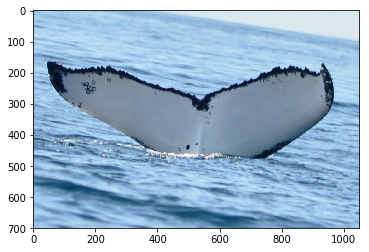

In [17]:
plt.imshow(preprocess_input(img1))

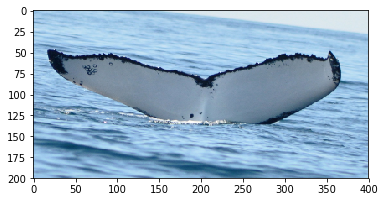

In [78]:
plt.imshow(cv2.resize(img1,(400,200)))

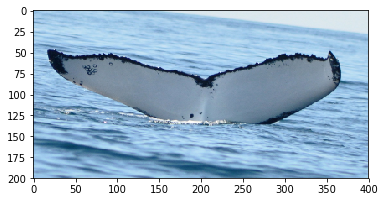

In [80]:
plt.imshow(cv2.resize(img1,(400,200)))

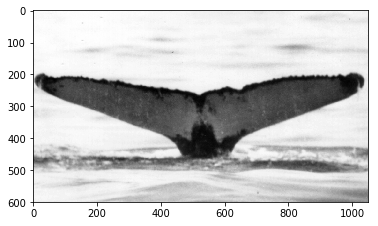

In [22]:
plt.imshow(img2,cmap='gray')

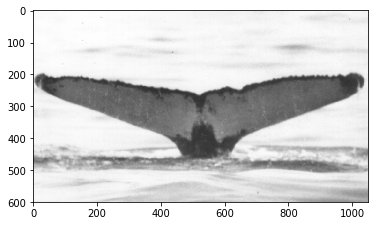

In [46]:
plt.imshow(np.tile(img2[:,:,np.newaxis],(1, 1, 3)))

In [44]:
img2.shape

(600, 1050)

In [45]:
np.tile(img2[:,:,np.newaxis],(1, 1, 3))

(600, 1050, 3)

In [23]:
img1.shape

(700, 1050, 3)

In [24]:
[os.path.getsize() for file in os.listdir()]

105048

In [26]:
img2.nbytes/105048

5.9972583961617545

In [27]:
os.path.getsize(train_folder+'/000f0f2bf.jpg')

186793

In [29]:
img1.nbytes/186793

11.804510875675213